<a href="https://colab.research.google.com/github/AbdulHamidDabboussi/HIV-1-Protease-Cleavage-Classifier/blob/master/CS464_HW1_HIV_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mounting Drive and Accessing Files

In [0]:
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive/My\ Drive/Bilkent/Year\ 3/CS464

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
hw3		q2_dataset.mat	     q2_test_set.txt
q1_dataset.mat	q2_gag_sequence.txt  q2_train_set.txt


# Bernoulli Naive Bayes Model

## Import Libraries

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

## Question 3.1

### Calculate Parameters and MLEs

In [0]:
root = '/gdrive/My Drive/Bilkent/Year 3/CS464'
train_path = os.path.join(root, 'q2_train_set.txt')

y_0 = []
y_1 = []

with open(train_path, "r") as file:
    for line in file:
        current_line = line.split(",")
        current_line = list(map(int, current_line))
        if current_line[-1] == 0:
            y_0.append(current_line)
        else:
            y_1.append(current_line)

    y_0 = np.array(y_0)
    y_1 = np.array(y_1)

    n_0 = len(y_0)
    n_1 = len(y_1)
    n = n_0 + n_1
    
    prob_y_0 = n_0 / n # P(Y = 0)
    prob_y_1 = n_1 / n # P(Y = 1)


    t_0 = np.split(np.sum(y_0, 0)[:-1], 8)
    t_1 = np.split(np.sum(y_1, 0)[:-1], 8)

    #calculate P(Xj | Y = y)
    theta_0 = np.divide(t_0, n_0)
    theta_1 = np.divide(t_1, n_1)


### Naive Bayes Training and Testing

Below, the MLEs prediously calculated in the above section on the training set will be used to predict results on the testing set. The accuracy of the model will be calculated and returned. 

In [0]:
def naive_bayes():
    test_path = os.path.join(root, 'q2_test_set.txt')

    test_set = []

    with open(test_path, "r") as file:
        for line in file:
            current_line = line.split(",")
            current_line = list(map(int, current_line))
            test_set.append(current_line)

    test_set = np.array(test_set)

    predictions = []
    actual = []

    for sequence in test_set:
        log_sum_0 = 0
        log_sum_1 = 0
        for i in range (0, 8):
            for j in range (0, 20):
                if sequence[j+20*i] == 1: 
                    log_sum_0 += np.log(theta_0[i][j])
                    log_sum_1 += np.log(theta_1[i][j])
        
        if (np.log(prob_y_0) + log_sum_0 < np.log(prob_y_1) + log_sum_1):
            predictions.append(1)
        else:
            predictions.append(0) 
        
        actual.append(sequence[-1])
   
    correct = 0
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    for g_y, p_y in zip(actual, predictions):
        if g_y == p_y: 
            correct += 1
        if p_y == 0 and g_y == 0:
            TN += 1
        if p_y == 0 and g_y == 1:
            FN += 1
        if p_y == 1 and g_y == 0:
            FP += 1
        if p_y == 1 and g_y == 1:
            TP += 1
            

    print("TN = " + str(TN))
    print("TP = " + str(TP))
    print("FN = " + str(FN))
    print("FP = " + str(FP))
    
    return (np.around((correct/float(len(actual))*100), decimals = 2))

print("Accuracy is: " + str(naive_bayes()) + "%")

TN = 422
TP = 79
FN = 18
FP = 9
Accuracy is: 94.89%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log


The accuracy of testing the above model is 94.89%.

## Question 3.2

### One-hot Encoding the Polyprotein

Below, the "Group-specific antigen" (gag) polyprotein sequence provided is transformed into a 493 x 160 sequence of ohe-hot encoded 8-*mers*

In [0]:
def gag_to_8_mer(file_path):
    amino_acids = {'g': 0, 'p': 1, 'a': 2, 'v': 3, 'l': 4, 'i': 5, 'm': 6, 'c': 7, 'f': 8, 'y': 9, 'w': 10, 'h': 11, 'k': 12, 'r': 13, 'q': 14, 'n': 15, 'e': 16, 'd': 17, 's': 18, 't': 19}
    sequences = np.zeros(shape = (493, 160), dtype = int)

    
    with open(file_path, "r") as file:
        gag = file.read()
        
        #produce one-hot 8-mers from gag
        for i in range(0, 493):
            for c in range(0, 8):
                sequences[i][20*c + amino_acids[gag[i+c].lower()]] = 1
    return sequences

In [0]:
sequences = gag_to_8_mer(os.path.join(root, 'q2_gag_sequence.txt'))

### Applying Naive Bayes to Find Cleavage Location 

Next, the trained model is used to find all locations where HIV-1 PT would cleave the gag popyprotein.

In [0]:
def find_cleave(sequences):
    predictions = []
    psudo_probs_0 = [] #psudo probability that the model used to classify as 0
    psudo_probs_1 = [] #psudo probability that the model used to classify as 1

    for sequence in sequences:
        log_sum_0 = 0
        log_sum_1 = 0
        for i in range (0, 8):
            for j in range (0, 20):
                if sequence[j+20*i] == 1: 
                    log_sum_0 += np.log(theta_0[i][j])
                    log_sum_1 += np.log(theta_1[i][j])
        
        if (np.log(prob_y_0) + log_sum_0 < np.log(prob_y_1) + log_sum_1):
            predictions.append(1)
            psudo_probs_1.append(np.log(prob_y_1) + log_sum_1)
        else:
            predictions.append(0)
            psudo_probs_0.append(np.log(prob_y_0) + log_sum_0)
    
    locations = []
    for i in range(0, 493):
        if predictions[i] == 1:
            locations.append(str(i+3) + '-' + str(i+4))

    return locations, psudo_probs_0, psudo_probs_1

In [0]:
locations, psudo_probs_0, psudo_probs_1 = find_cleave(sequences)
print(locations)

['5-6', '42-43', '60-61', '79-80', '131-132', '183-184', '196-197', '215-216', '295-296', '315-316', '320-321', '341-342', '342-343', '362-363', '366-367', '376-377', '447-448', '465-466', '467-468', '482-483']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


Above, the cleaves found are printed.

## Question 3.3

### 8-mer Generation

Below, the 8-mer assigned to class 1 with highest probability and the 8-mer assigned to class 0 with the lowest probability are both generated.

In [0]:
def generate_sequence():
    amino_acids = ['g', 'p', 'a', 'v', 'l', 'i', 'm', 'c', 'f', 'y', 'w', 'h', 'k', 'r', 'q', 'n', 'e', 'd', 's', 't']

    max_sequence = np.argmax(theta_1, 1)
    min_sequence = np.argmin(theta_0, 1)

    generated_sequence_0 = ""
    generated_sequence_1 = ""

    for i in range (0, 8):
        generated_sequence_0 += (amino_acids[min_sequence[i]])
        generated_sequence_1 += (amino_acids[max_sequence[i]])

    print("8-mer assigned to class 1 with max probability is: " + generated_sequence_1.upper())
    print("8-mer assigned to class 0 with min probability is: "+ generated_sequence_0.upper())


In [0]:
generate_sequence()

8-mer assigned to class 1 with max probability is: SAVLLEAT
8-mer assigned to class 0 with min probability is: WWWWWWWW


## Question 3.4

### Naive Bayes With Laplase Smoothing

In this section, Laplace smoothing will be used with different alpha values to learn MAP estimators. Essentially tweaking the previous model and contrasting the differences.

In [0]:
def naive_bayes_laplace(alpha):

    smooth_theta_0 = np.divide(np.add(t_0, alpha), n_0 + 2*alpha)
    smooth_theta_1 = np.divide(np.add(t_1, alpha), n_1 + 2*alpha)
    
    test_path = os.path.join(root, 'q2_test_set.txt')

    test_set = []

    with open(test_path, "r") as file:
        for line in file:
            current_line = line.split(",")
            current_line = list(map(int, current_line))
            test_set.append(current_line)

    test_set = np.array(test_set)

    predictions = []
    actual = []

    for sequence in test_set:
        log_sum_0 = 0
        log_sum_1 = 0
        for i in range (0, 8):
            for j in range (0, 20):
                if sequence[j+20*i] == 1: 
                    log_sum_0 += np.log(smooth_theta_0[i][j])
                    log_sum_1 += np.log(smooth_theta_1[i][j])
        
        if (np.log(prob_y_0) + log_sum_0 < np.log(prob_y_1) + log_sum_1):
            predictions.append(1)
        else:
            predictions.append(0) 
        
        actual.append(sequence[-1])
   
    correct = 0
    for g_y, p_y in zip(actual, predictions):
        if g_y == p_y: 
            correct += 1
            
    return (np.around((correct/float(len(actual))*100), decimals=2))

Now the accuracy with different alpha values is calculated and plotted

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


Accuracy for alpha = 0 is: 94.89%
Accuracy for alpha = 1 is: 94.7%
Accuracy for alpha = 2 is: 94.51%
Accuracy for alpha = 3 is: 94.51%
Accuracy for alpha = 4 is: 94.51%
Accuracy for alpha = 5 is: 94.51%
Accuracy for alpha = 6 is: 94.13%
Accuracy for alpha = 7 is: 93.75%
Accuracy for alpha = 8 is: 93.56%
Accuracy for alpha = 9 is: 92.99%
Accuracy for alpha = 10 is: 92.8%


<function matplotlib.pyplot.show>

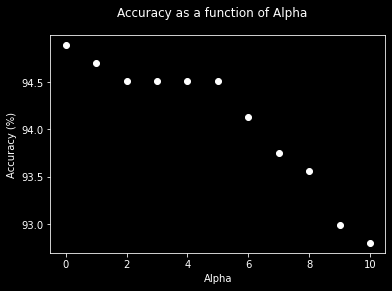

In [0]:
ls = []
for alpha in range (0, 11):
    ls.append(naive_bayes_laplace(alpha))
    print("Accuracy for alpha = " + str(alpha) + " is: " + str(naive_bayes_laplace(alpha)) + "%")

plt.style.use(['dark_background'])
plt.plot(ls, 'wo')
plt.ylabel('Accuracy (%)')
plt.xlabel('Alpha')
plt.suptitle('Accuracy as a function of Alpha')
plt.show

As seen in the above graph, the test accuracy decreases as alpha values increase for sufficiently large train sets.

Now, only 75 rows will be used to train the model.

In [0]:
def weak_naive_bayes(alpha):

    y_0_small = []
    y_1_small = []

    i = 0
    with open(train_path, "r") as file:
        for line in file:
            if (i >= 75):
                break
            i += 1
            current_line = line.split(",")
            current_line = list(map(int, current_line))
            if current_line[-1] == 0:
                y_0_small.append(current_line)
            else:
                y_1_small.append(current_line)

    y_0_small = np.array(y_0_small)
    y_1_small = np.array(y_1_small)
    
    n_0_small = len(y_0_small)
    n_1_small = len(y_1_small)
    n_small = n_0_small + n_1_small

    prob_y_0 = n_0_small / n_small # P(Y = 0)
    prob_y_1 = n_1_small / n_small # P(Y = 1)

    t_0_small = np.split(np.sum(y_0_small, 0)[:-1], 8)
    t_1_small = np.split(np.sum(y_1_small, 0)[:-1], 8)

    #calculate P(Xj | Y = y)
    smooth_theta_0 = np.divide(np.add(t_0_small, alpha), n_0_small + 2*alpha)
    smooth_theta_1 = np.divide(np.add(t_1_small, alpha), n_1_small + 2*alpha)
    
    test_path = os.path.join(root, 'q2_test_set.txt')

    test_set = []

    with open(test_path, "r") as file:
        for line in file:
            current_line = line.split(",")
            current_line = list(map(int, current_line))
            test_set.append(current_line)

    test_set = np.array(test_set)

    predictions = []
    actual = []

    for sequence in test_set:
        log_sum_0 = 0
        log_sum_1 = 0
        for i in range (0, 8):
            for j in range (0, 20):
                if sequence[j+20*i] == 1: 
                    log_sum_0 += np.log(smooth_theta_0[i][j])
                    log_sum_1 += np.log(smooth_theta_1[i][j])
        
        if (np.log(prob_y_0) + log_sum_0 < np.log(prob_y_1) + log_sum_1):
            predictions.append(1)
        else:
            predictions.append(0) 
        
        actual.append(sequence[-1])
   
    correct = 0
    for g_y, p_y in zip(actual, predictions):
        if g_y == p_y: 
            correct += 1
            
    return (np.around((correct/float(len(actual))*100), decimals=2))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


Accuracy for alpha = 0 is: 84.85%
Accuracy for alpha = 1 is: 48.3%
Accuracy for alpha = 2 is: 24.81%
Accuracy for alpha = 3 is: 18.75%
Accuracy for alpha = 4 is: 18.56%
Accuracy for alpha = 5 is: 18.37%
Accuracy for alpha = 6 is: 18.37%
Accuracy for alpha = 7 is: 18.37%
Accuracy for alpha = 8 is: 18.37%
Accuracy for alpha = 9 is: 18.37%
Accuracy for alpha = 10 is: 18.37%


<function matplotlib.pyplot.show>

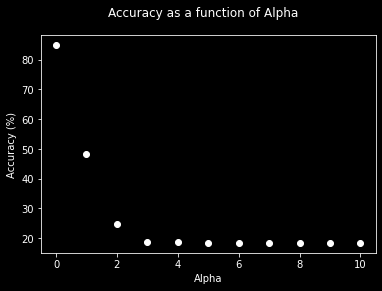

In [0]:
ls = []
for alpha in range (0, 11):
    ls.append(weak_naive_bayes(alpha))
    print("Accuracy for alpha = " + str(alpha) + " is: " + str(weak_naive_bayes(alpha)) + "%")

plt.style.use(['dark_background'])
plt.plot(ls, 'wo')
plt.ylabel('Accuracy (%)')
plt.xlabel('Alpha')
plt.suptitle('Accuracy as a function of Alpha')
plt.show

***Q 3.4 NEEDS ANALYSIS SECTION REGARDING LAPLACE SMOOTHING***

## Question 3.5

### Mutual Information

Below, the mutual information between each of the 160 features and the labels in the training set will be calculated and sorted.

In [0]:
def mutual_information():
    train_path = os.path.join(root, 'q2_train_set.txt')

    y_0 = []
    y_1 = []

    with open(train_path, "r") as file:
        for line in file:
            current_line = line.split(",")
            current_line = list(map(int, current_line))
            if current_line[-1] == 0:
                y_0.append(current_line[:-1])
            else:
                y_1.append(current_line[:-1])

    y_0 = np.array(y_0)
    y_1 = np.array(y_1)

    #array of feature stats 
    N_10 = np.sum(y_0, 0)
    N_11 = np.sum(y_1, 0)
    N_00 = np.subtract(n_0, N_10)
    N_01 = np.subtract(n_1, N_11)

    #print(np.prod(N_00))
    #print(np.prod(N_01))
    # print(N_00)
    # print(N_01)
    # print(N_10)
    # print(N_11)


    mutual_information = np.add(np.add(np.multiply(np.divide(N_11, n), np.log2(np.divide(np.multiply(n, N_11), np.multiply((np.add(N_10, N_11)),(np.add(N_01, N_11)))))),
                                       np.multiply(np.divide(N_01, n), np.log2(np.divide(np.multiply(n, N_01), np.multiply((np.add(N_00, N_01)),(np.add(N_01, N_11))))))),
                                np.add(np.multiply(np.divide(N_10, n), np.log2(np.divide(np.multiply(n, N_10), np.multiply((np.add(N_10, N_11)),(np.add(N_00, N_10)))))),
                                       np.multiply(np.divide(N_00, n), np.log2(np.divide(np.multiply(n, N_00), np.multiply((np.add(N_00, N_01)),(np.add(N_00, N_10))))))))
    #print(type(mutual_information[0]) == np.float64)
    for i in range(np.shape(mutual_information)[0]):
        if (np.isnan(mutual_information[i])):
            mutual_information[i] = np.inf
            
    sort_index = np.argsort(mutual_information)[::-1]
    mutual_information = np.sort(mutual_information)[::-1]
    return sort_index, mutual_information

    


In [0]:
sort_index, mutual_information = mutual_information()

[1.49244680e-04 2.57799890e-02 2.24641345e-03 8.86961823e-03
 7.85727339e-03 4.60604031e-03 9.94829482e-04 4.49260021e-05
 1.63495273e-03 7.89346870e-04 9.57140774e-04 1.53083737e-05
 3.99160574e-03 2.68828837e-07 1.96616807e-03 1.61561291e-03
 1.61338015e-03 5.30599966e-05 2.27334229e-02 1.01913031e-05
 1.03249522e-03 5.00086061e-03 6.92106728e-04 6.04098605e-03
 7.66176745e-05 3.13301957e-03 2.35218010e-04 8.57458269e-06
 4.79114545e-03 4.20423946e-05 5.29139286e-04 7.57155390e-05
 2.13093624e-04 1.67450348e-02 3.88582210e-03 4.70335415e-03
 8.59019756e-04 2.20671617e-04 2.58240832e-03 1.65098355e-03
 8.01823055e-03 1.28619604e-02 4.94280290e-05 5.09553092e-02
 4.09810515e-03 3.17690821e-03 9.06281518e-04 2.00540871e-05
 1.64736549e-03 2.33431854e-03 1.10701533e-03 1.82889151e-03
            inf 4.37598339e-03 8.65657781e-03 7.10481469e-03
 4.13058248e-03 6.10523063e-05 9.85297800e-03 3.67873488e-08
 3.80472925e-03            inf 2.56996797e-03 1.42758889e-02
 3.04343234e-02 8.367243

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


Train the model using top k features found using mutual information.


In [0]:
def train_select_features(features):
    t_0 = np.zeros(shape = (8, 20), dtype = int)
    t_1 = np.zeros(shape = (8, 20), dtype = int)

    #calculate T i,j,y=0
    for sequence in range (0, n_0):
        for i in range (0, 8):
            for j in range (0, 20):
                # if np.isin(j+20*i, features):
                    if y_0[sequence][j+20*i] == 1:
                        t_0[i][j] += 1
    
    #calculate T i,j,y=1
    for sequence in range (0, n_1):
        for i in range (0, 8):
            for j in range (0, 20):
                # if np.isin(j+20*i, features):
                    if y_1[sequence][j+20*i] == 1:
                        t_1[i][j] += 1


    sum_t_0 = np.sum(t_0, 1)
    sum_t_1 = np.sum(t_1, 1)
    
    theta_0 = np.zeros(shape = (8, 20))             
    theta_1 = np.zeros(shape = (8, 20)) 

    #calculate P(Xj | Y = y)
    for i in range (0, 8):
        for j in range (0, 20):
            theta_0[i][j] = np.divide(t_0[i][j], sum_t_0[i]) 
            theta_1[i][j] = np.divide(t_1[i][j], sum_t_1[i]) 




Test the accuracy of the model with k features

In [0]:
def test_features(features):
   
    predictions = []
    actual = []

    for sequence in test_set:
        log_sum_0 = 0
        log_sum_1 = 0
        for i in range (0, 8):
            for j in range (0, 20):
                if np.isin(j+20*i, features):
                    if sequence[j+20*i] == 1: 
                        log_sum_0 += np.log(theta_0[i][j])
                        log_sum_1 += np.log(theta_1[i][j])
        
        if (np.log(prob_y_0) + log_sum_0 < np.log(prob_y_1) + log_sum_1):
            predictions.append(1)
        else:
            predictions.append(0) 
        
        actual.append(sequence[-1])
   


    correct = 0
    for g_y, p_y in zip(actual, predictions):
        if g_y == p_y: 
            correct += 1
            
    return (np.around((correct/float(len(actual))*100), decimals = 2))

The below code section runs the code on different k values between 1 and 160 to determine the best k. This section takes ~60 seconds to execute.

In [0]:
test_path = os.path.join(root, 'q2_test_set.txt')

test_set = []

with open(test_path, "r") as file:
    for line in file:
        current_line = line.split(",")
        current_line = list(map(int, current_line))
        test_set.append(current_line)

test_set = np.array(test_set)
accuracy_list = []
for k in range(1, 161):
    # train_select_features(sort_index[0:k])
    acc = test_features(sort_index[0:k])
    print("Accuracy for k = " + str(k) + " is: " + str(acc) + "%")
    accuracy_list.append(acc)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


Accuracy for k = 1 is: 81.63%
Accuracy for k = 2 is: 81.63%
Accuracy for k = 3 is: 82.77%
Accuracy for k = 4 is: 84.66%
Accuracy for k = 5 is: 84.66%
Accuracy for k = 6 is: 85.98%
Accuracy for k = 7 is: 87.12%
Accuracy for k = 8 is: 86.36%
Accuracy for k = 9 is: 85.23%
Accuracy for k = 10 is: 84.66%
Accuracy for k = 11 is: 84.09%
Accuracy for k = 12 is: 83.71%
Accuracy for k = 13 is: 83.14%
Accuracy for k = 14 is: 82.2%
Accuracy for k = 15 is: 83.71%
Accuracy for k = 16 is: 84.09%
Accuracy for k = 17 is: 84.85%
Accuracy for k = 18 is: 84.85%
Accuracy for k = 19 is: 85.04%
Accuracy for k = 20 is: 85.8%
Accuracy for k = 21 is: 86.55%
Accuracy for k = 22 is: 88.07%
Accuracy for k = 23 is: 88.64%
Accuracy for k = 24 is: 88.83%
Accuracy for k = 25 is: 88.45%
Accuracy for k = 26 is: 88.64%
Accuracy for k = 27 is: 89.2%
Accuracy for k = 28 is: 89.58%
Accuracy for k = 29 is: 89.39%
Accuracy for k = 30 is: 90.15%
Accuracy for k = 31 is: 90.34%
Accuracy for k = 32 is: 90.34%
Accuracy for k = 33 

In [0]:
result = np.argmax(accuracy_list)
print("Max accuracy of " + str(np.amax(accuracy_list)) + "% was achieved at k = " + str(result + 1))

Max accuracy of 95.27% was achieved at k = 121


Looking at the result above, and measuring accuracy to the second decimal place, the largest accuracy obtained is 95.27% for k values (121-126). Greater than the accuracy measured in part 3.1 at 94.89%. As such, taking the least of these k values, 121 would result in the highest accuracy - lowest training time combination.

It is important to note, however, that going as low as k = 30 features will still result in greater than 90% accuracy.

## Question 3.6

### Principal Component Analysis

In this part, Principal Component Analysis is applied in the dataset. Singular Value Decomposition (SVD) is used to calculate the Principle Components for efficiency.

In [0]:
def svd(X, k):
    U, S, V_t = np.linalg.svd(X, full_matrices=False)
    pve = np.divide((np.sum(np.square(S[:k]))), np.sum(np.square(S)))

    print("PVE = " + str(pve))
    return np.dot(U[:, 0:k], np.diag(S)[0:k, 0:k])

In [0]:
train_path = os.path.join(root, 'q2_train_set.txt')

data_set = []
y_t = [] #class 1
y_f = [] #class 0

with open(train_path, "r") as file:
    for line in file:
        current_line = line.split(",")
        current_line = list(map(int, current_line))
        data_set.append(current_line[:-1])
        if current_line[-1] == 0:
            y_f.append(current_line[:-1])
        else:
            y_t.append(current_line[:-1])
        
data_set = np.array(data_set)
data_set = np.array(data_set)
data_set = np.array(data_set)

print("PCA on full Dataset")
data_set_PC = svd(data_set, 3)
print("PCA on Class 0")
y_0_PC = svd(y_1, 3)
print("PCA on Class 1")
y_1_PC = svd(y_t, 3)

PCA on full Dataset
PVE = 0.11192559479979312
PCA on Class 0
PVE = 0.340538879074019
PCA on Class 1
PVE = 0.2627692148264629


Now that top 3 principal components have been identified and the dataset has been projected on a new space with 3 dimensions, the 3D scatterplot of the top 3 features of the 6062 polyprotein 8-mers is shows below.

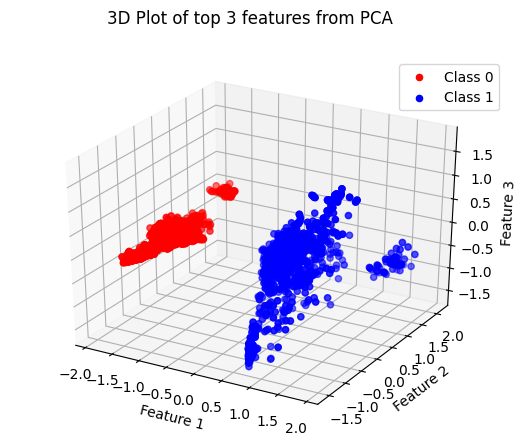

In [0]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

axis = data_set_PC.T #if you want to plot the whole data as one
axis_0 = y_0_PC.T
axis_1 = y_1_PC.T


ax.scatter(axis_0[0], axis_0[1], c='r', label = 'Class 0')
ax.scatter(axis_1[0], axis_1[1], axis_1[2], c='b', label = 'Class 1')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
plt.suptitle('3D Plot of top 3 features from PCA')
plt.style.use(['default'])
plt.show()


As seen above, the Proportion of Variance Explained (PVE) for the obtained principal components is 11% - very low. Which is to be expected because 160 features were reduced to only 3. Since the PVE is very low, applying PCA with only the top 3 PCs is not enough for the given dataset.